In [1]:
from collections import defaultdict, deque
import random
import numpy as np
import os
from typing import *
from tqdm import tqdm
import networkx as nx
from matplotlib import pyplot as plt

DEFAULT_DATA_FOLDER = "./networks"

In [109]:
def read(filepath):
    G = nx.Graph()
    with open(filepath, 'r', encoding="utf-8") as file:
        line = file.readline()
        n = int(line.strip().split(" ")[1])
        for _ in range(n):
            parts = file.readline().strip().split("!")
            id = int(parts[0])
            name = parts[1]
            label = parts[2].strip()
            G.add_node(id, name=name, label=label)
        line = file.readline()
        m = int(line.strip().split(" ")[1])
        for _ in range(m):
            parts = file.readline().strip().split(" ")
            G.add_edge(int(parts[0]), int(parts[1]))
    return nx.convert_node_labels_to_integers(G)


filepath = "works.net"
G = read(filepath)
n = G.number_of_nodes()
m = G.number_of_edges()
G.name = "works"
print(n)
print(m)

6478
31070


In [3]:
# vir: https://github.com/lovre/www/blob/master/ina/labs/utils.py

def info(G: nx.Graph, distance_sample: int | None = None,
         clustering_sample: int | None = 10_000) -> None:
    """Prints basic information on the provided graph.
    - If distance_sample is given, distance statistics will be computed from
    a sample of nodes (of given size).
    - If clustering_sample is given, average clustering will be computed from
    a sample of nodes (of given size).
    """
    print("{:>12s} | '{:s}'".format(str(G).split()[0], G.name))

    n = G.number_of_nodes()
    m = G.number_of_edges()

    print("{:>12s} | {:,d} (iso={:,d})".format(
        'Nodes', n, nx.number_of_isolates(G)))
    print("{:>12s} | {:,d} (loop={:,d})".format(
        'Edges', m, nx.number_of_selfloops(G)))

    if G.is_directed():
        print("{:>12s} | {:.2f} max(in={:d}, out={:d})".format(
            'Degree', m / n, max(k for _, k in G.in_degree()),
            max(k for _, k in G.out_degree())))
    else:
        print("{:>12s} | {:.2f} (max={:,d})".format(
            'Degree', 2 * m / n, max((k for _, k in G.degree()))))

    C = list(nx.connected_components(nx.Graph(G) if G.is_directed else G))
    largest_comp = max(C, key=len)

    print("{:>12s} | {:.1f}% (n={:,d})".format(
        'LCC', 100 * len(largest_comp) / n, len(C)))

    if distance_sample is not None:
        G_lcc = G.subgraph(largest_comp)
        if n <= distance_sample:
            mean = nx.average_shortest_path_length(G_lcc)
            diam = nx.diameter(G_lcc)
        else:
            D = distances(G_lcc, n=distance_sample)
            mean = np.mean(D)
            diam = max(D)

        print("{:>12s} | {:.2f} (max={:,d})".format('Distance', mean, diam))

    if clustering_sample is not None:
        if isinstance(G, nx.MultiGraph):
            G = nx.Graph(G)

        clustering_on = G.nodes if n <= clustering_sample \
            else random.sample(list(G.nodes), k=clustering_sample)

        print("{:>12s} | {:.4f}".format(
            'Clustering', nx.average_clustering(G, clustering_on)))
    print()

In [4]:
# vir: https://github.com/lovre/www/blob/master/ina/labs/utils.py

def plot_degree(G: nx.Graph, save_path: str | None = None) -> None:
    """Plots degree distribution(s) on a log-log plot.
    If save_path is given, the plot will be saved in given folder/file
    instead of being shown."""
    plt.clf()
    plt.title(G.name + " degree distribution")
    plt.ylabel('$p_k$')
    plt.xlabel('$k$')
    n = G.number_of_nodes()

    def aux(degree_view: Iterable, k_min: int, **kwargs):
        degree_count = Counter(k for _, k in degree_view)
        k_max = max(degree_count.keys())

        x = list(range(k_min, k_max + 1))
        y = [degree_count[i] / n for i in x]
        plt.loglog(x, y, 'o', **kwargs)

    if G.is_directed():
        aux(G.out_degree, k_min=0, label="outdegree", color="pink")
        aux(G.in_degree, k_min=0, label="indegree", color="purple", alpha=0.5)
        plt.legend()
    else:
        aux(G.degree, k_min=1, color="gray")

    if save_path is None:
        plt.show()
    else:
        if len(os.path.splitext(save_path)[1]) == 0: # no extension
            plt.savefig(os.path.join(save_path, f"{G.name}_degree_distro.pdf"))
        else:
            plt.savefig(save_path)

       Graph | 'works'
       Nodes | 6,478 (iso=81)
       Edges | 31,070 (loop=0)
      Degree | 9.59 (max=6,082)
         LCC | 98.7% (n=82)
  Clustering | 0.0000



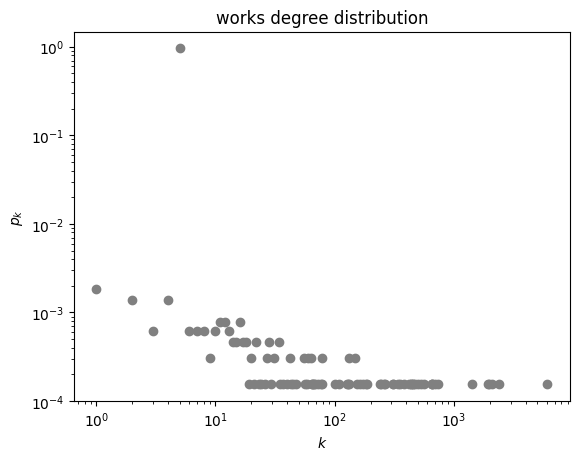

In [5]:
info(G)
plot_degree(G)

In [6]:
def find_node(G: nx.Graph, label: str):
    """Finds node with given label in G."""
    for i, data in G.nodes(data=True):
        if data['name'] == label:
            return i
    raise ValueError(f"node '{label}' not found in {G.name}")

In [98]:
# vir: https://github.com/lovre/www/blob/master/ina/labs/utils.py

def top_nodes(G: nx.Graph, C: Dict[Any, float], centrality: str, n=15, filter=[]) -> List[Any]:
    """prints and returns top n nodes by given measure of centrality"""

    # OPT take callable instead of dict, only compute centrality on non-mode nodes
    # OPT np.argpartition instead of sort
    print("{:>12s} | '{:s}'".format('Centrality', centrality))
    nodes = []
    filtered = C.items()
    if len(filter) > 0:
        filtered = [(node, pr) for node, pr in filtered if G.nodes[node]['label'] in filter]
    for i, c in sorted(filtered, key=lambda item: (item[1], G.degree[item[0]]), reverse=True):
        # if G.nodes[i]['label'] == 'Key':
        nodes.append(G.nodes[i])
        print("{:>12.6f} | '{:s}' ({:,d}) '{:s}'".format(
            c, G.nodes[i]['label'], G.degree[i], G.nodes[i]['name'][:30]))
        n -= 1
        if n == 0:
            break
    print()
    return nodes


def nodes_names(nodes) -> List[str]:
    """Parses labels of nodes in collaboration_imdb.net into
    a nicer format. Try pasting the ouput of this function into
    chatGPT if you have trouble classifying the actors."""
    names = []
    for n in nodes:
        try:
            last, fst = n["label"].split(", ")
            if fst[-1] == ')':
                fst = fst[:fst.index('(') - 1]

            names.append(f"{fst} {last}")
        except ValueError: # failed unpacking
            names.append(n["label"])

    return names


In [151]:
def pagerank(G: nx.Graph, alpha=0.85, eps=1e-6, teleport: list | None=None, weights: list | None=None):
    P = [1 / len(G)] * len(G)
    diff = 1
    # If weights is not none, put appropriate weight on the nodes,
    # inversely proportional to their degree
    while diff > eps:
        U = [sum([P[j] * alpha / G.degree(j) for j in G[i]])
             for i in G.nodes()]
        u = sum(U)
        if teleport is not None:
            if weights is not None:
                for ix, i in enumerate(teleport):
                    w = weights[ix]
                    U[i] += w
            else:
                for i in teleport:
                    U[i] += (1 - u) / len(teleport)
            c = sum(U)
            U = [u / c for u in U]
        else:
            U = [U[i] + (1 - u) / len(G) for i in G.nodes()]
        c = sum(U)
        diff = sum([abs(P[i] - U[i]) for i in G.nodes()])
        P = U
    return {i: P[i] for i in range(len(P))}

In [157]:
def calculate_pr_weights(G):
    popular = find_node(G, "Popular")
    all_popular = list(G.neighbors(popular))
    all_keys = [node['name'] for ix, node in G.nodes(data=True) if node['label'] == 'Key']
    node_to_key = {}
    key_to_degree = {key: 0 for key in all_keys}
    for node in all_popular:
        for n in G.neighbors(node):
            if G.nodes(data=True)[n]['label'] == 'Key':
                node_to_key[node] = G.nodes(data=True)[n]['name']
                key_to_degree[G.nodes(data=True)[n]['name']] += 1
    weights = [key_to_degree[node_to_key[node]] if key_to_degree[node_to_key[node]] != 0 else 0 for node in all_popular]
    weights2 = [sum(key_to_degree.values())/w for w in weights]
    weights3 = [w/sum(weights2) for w in weights2]
    #for w, f, frac in zip(weights, weights2, weights3):
    #    print(f"{w}, {f}, {frac}")
    return weights3

weights = calculate_pr_weights(G)

In [158]:
popular_node = find_node(G, "Popular")
nonpopular_node = find_node(G, "Nonpopular")
#print(G.nodes(data=True)[popular_node])
popular_neighbors = list(G.neighbors(popular_node))
C = pagerank(G, teleport=popular_neighbors)
nodes = top_nodes(G, C, 'Pagerank', n=40, filter=['Key'])
weights = calculate_pr_weights(G)
C = pagerank(G, teleport=popular_neighbors, weights=weights)
nodes = top_nodes(G, C, 'Weighted pagerank', n=40, filter=['Key'])

  Centrality | 'Pagerank'
    0.009119 | 'Key' (659) 'D major'
    0.009006 | 'Key' (654) 'C major'
    0.007443 | 'Key' (420) 'G minor'
    0.007356 | 'Key' (458) 'E flat major'
    0.007148 | 'Key' (438) 'D minor'
    0.006338 | 'Key' (472) 'F major'
    0.006166 | 'Key' (531) 'G major'
    0.005924 | 'Key' (501) 'B flat major'
    0.005872 | 'Key' (309) 'C minor'
    0.005314 | 'Key' (351) 'A minor'
    0.004787 | 'Key' (383) 'A major'
    0.004358 | 'Key' (247) 'E minor'
    0.002826 | 'Key' (153) 'B minor'
    0.002669 | 'Key' (174) 'E major'
    0.002505 | 'Key' (149) 'F minor'
    0.001062 | 'Key' (22) 'B flat minor'
    0.000959 | 'Key' (67) 'A flat major'
    0.000853 | 'Key' (64) 'F sharp minor'
    0.000729 | 'Key' (42) 'C sharp minor'
    0.000599 | 'Key' (34) 'D flat major'
    0.000256 | 'Key' (28) 'B major'
    0.000209 | 'Key' (20) 'E flat minor'
    0.000186 | 'Key' (18) 'F sharp major'
    0.000103 | 'Key' (10) 'G flat major'
    0.000044 | 'Key' (5) 'G sharp minor'
 

In [117]:
print(G.nodes[248]['label'])

Key


In [72]:
popular_node = find_node(G, "Popular")
#print(G.nodes(data=True)[popular_node])
popular_neighbors = set(G.neighbors(popular_node))
C = pagerank(G, teleport=popular_neighbors)
nodes2 = top_nodes(G, C, 'Pagerank', n=40, filter=['Key'])
nodes2

  Centrality | 'Pagerank'


TypeError: 'int' object is not subscriptable

In [12]:
nodes_names(top_nodes(tmpG, pagerank(tmpG, teleport=popular_neighbors), "PageRank"))

  Centrality | 'PageRank'
    0.048260 | 'Popularity' (6,082) 'Nonpopular'
    0.025207 | 'Genre' (1,976) 'Orchestral'
    0.014877 | 'Genre' (2,098) 'Chamber'
    0.014567 | 'Period' (730) 'Romantic'
    0.011056 | 'Genre' (1,955) 'Keyboard'
    0.010871 | 'Period' (2,381) 'Baroque'
    0.010094 | 'Period' (694) 'Early Romantic'
    0.007285 | 'Period' (1,412) 'Classical'
    0.005602 | 'Key' (654) 'C major'
    0.005596 | 'Composer' (188) 'Ludwig van Beethoven'
    0.005364 | 'Period' (260) '20th Century'
    0.005145 | 'Key' (458) 'E flat major'
    0.005125 | 'Key' (501) 'B flat major'
    0.004981 | 'Work' (5) 'String Quartet no. 2 in A mino'
    0.004967 | 'Composer' (342) 'Wolfgang Amadeus Mozart'



ModuleNotFoundError: No module named 'scipy'

# Graph with randomly distributed edges

In [70]:
G_randomized = nx.Graph()
G_randomized.name = "randomized attributes"
G_randomized.add_nodes_from(G.nodes(data=True))
G_randomized.nodes(data=True)
type_of_nodes = {'Composer': (1, 220), 'Period': (221, 230), 'Popularity': (231, 232), 'Genre': (233, 237), 'Key': (238, 264), 'Work': (265, 6478)}

In [71]:
for work in range(type_of_nodes['Work'][0], type_of_nodes['Work'][1] + 1):
    for attr in G[work]:
        label = G.nodes[attr]['label']
        edge_end = random.randint(type_of_nodes[label][0], type_of_nodes[label][1])
        G_randomized.add_edge(work, edge_end)

       Graph | 'works'
       Nodes | 6,478 (iso=81)
       Edges | 31,070 (loop=0)
      Degree | 9.59 (max=6,082)
         LCC | 98.7% (n=82)
  Clustering | 0.0000

       Graph | 'randomized attributes'
       Nodes | 6,478 (iso=0)
       Edges | 31,070 (loop=0)
      Degree | 9.59 (max=3,110)
         LCC | 100.0% (n=1)
  Clustering | 0.0000



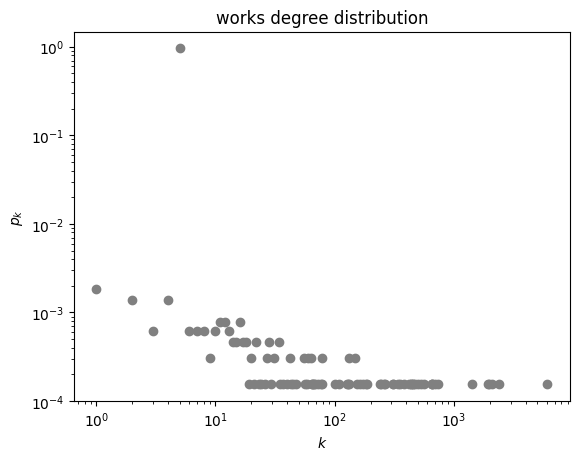

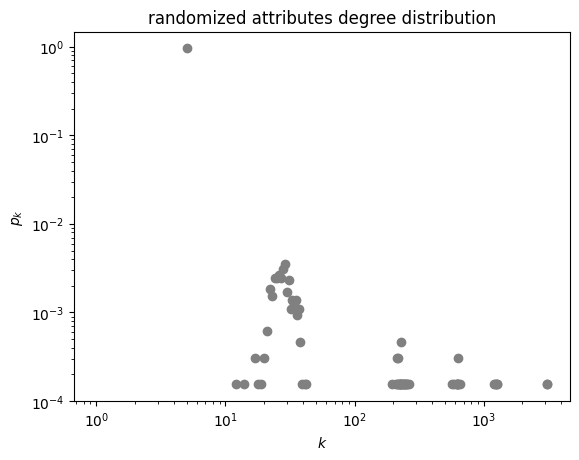

In [72]:
info(G)
info(G_randomized)
plot_degree(G)
plot_degree(G_randomized)